In [24]:
# %pip install transformer_lens # sae_lens
# %pip install matplotlib numpy scipy plotly pytest

# Setup

In [25]:
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader
from huggingface_hub import hf_hub_download
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader

### Get data

In [26]:
dataset = load_dataset("apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split='train', streaming=True)
shuffled_dataset = dataset.shuffle(seed=42, buffer_size=100)
dataloader = DataLoader(shuffled_dataset, batch_size=10)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

In [27]:
# Start by downloading them from huggingface
device = "cuda"
REPO_ID = "jbloom/GPT2-Small-SAEs"

def get_sae(layer):
    assert 0<=layer<12, "Layer must be between 0 and 11"
    FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

    # this is great because if you've already downloaded the SAE it won't download it twice!
    path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

    # We can then load the SAE, dataset and model using the session loader
    model, sparse_autoencoders, activation_store = (
        LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
    )
    assert len(list(sparse_autoencoders)) == 1, "There should only be one SAE in this file"
    return model, list(sparse_autoencoders)[0], activation_store

### Layer 8 SAE

In [28]:
model, sae_8, activation_store = get_sae(layer=8)
n_features = sae_8.cfg.d_sae

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.


### Layer 9 SAE

In [29]:
model, sae_9, activation_store = get_sae(layer=9)
n_features = sae_9.cfg.d_sae

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.


# Collect SAE feature activations

In [30]:
def get_feature_activation_table(sae, dataloader=dataloader, batches=100):
    layer = sae.cfg.hook_point_layer
    big_feature_activation_table = []
    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads
    for i, prompts in tqdm(enumerate(iter(dataloader)), desc=f"Getting activations for layer {layer}", total=batches):
        with torch.no_grad():
            prompts = torch.stack(prompts["input_ids"]).to(device)
            _, cache = model.run_with_cache(prompts, prepend_bos=True)
            _, feature_acts, _, _, _, _ = sae(
                cache[sae.cfg.hook_point]
            )
            del cache
            big_feature_activation_table.append(feature_acts.view(-1, n_features).cpu())
        if i==batches:
            break
    # for _ in tqdm(range(batches), desc=f"Getting activations for layer {layer}"):
    #     with torch.no_grad():
    #         batch_tokens = activation_store.get_batch_tokens()
    #         _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
    #         _, feature_acts, _, _, _, _ = sae(
    #             cache[sae.cfg.hook_point]
    #         )
    #         del cache
    #         big_feature_activation_table.append(feature_acts.view(-1, n_features).cpu())

    big_feature_activation_table = torch.cat(big_feature_activation_table, dim=0)
    return big_feature_activation_table

feature_activation_table_8 = get_feature_activation_table(sae_8)
feature_activation_table_9 = get_feature_activation_table(sae_9)

Getting activations for layer 9: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Text(0, 0.5, 'Histogram over total of 24576 features\nCut at x<100 because we want to make sure there are no low numbers')

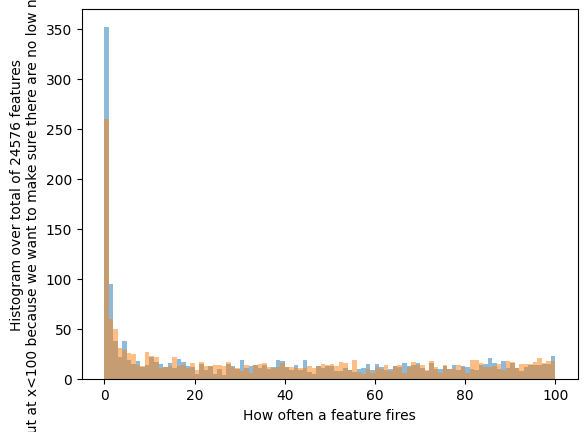

In [31]:
# Do we have a decent amount of activations for each feature?
plt.hist((feature_activation_table_8 != 0).sum(dim=0), range=(0, 100), bins=100, alpha=0.5)
plt.hist((feature_activation_table_9 != 0).sum(dim=0), range=(0, 100), bins=100, alpha=0.5)
plt.xlabel("How often a feature fires")
plt.ylabel(f"Histogram over total of {n_features} features\nCut at x<100 because we want to make sure there are no low numbers")

# Compute the correlations

In [32]:
feature_activation_table_9.shape

torch.Size([1034240, 24576])

In [33]:
cutoff = 200 #instead of 25k, for testing. 10k takes abour 20 seconds
a = feature_activation_table_8.T[:cutoff]
b = feature_activation_table_9.T[:cutoff]
print(a.shape)
# Compute correlation  between feature_activation_table_8 and feature_activation_table_9
# Compute the 20x20 correlation matrix using numpy
correlation_matrix = np.corrcoef(a,b)[:cutoff,cutoff:]

#plt.matshow(correlation_matrix)
#plt.colorbar()

torch.Size([200, 1034240])


/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/ssd-interp/stefan/hackathon/hackathon_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [34]:
edges = []
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        edges.append(((0, i), (1, j), correlation_matrix[i, j]))

# Create the graph

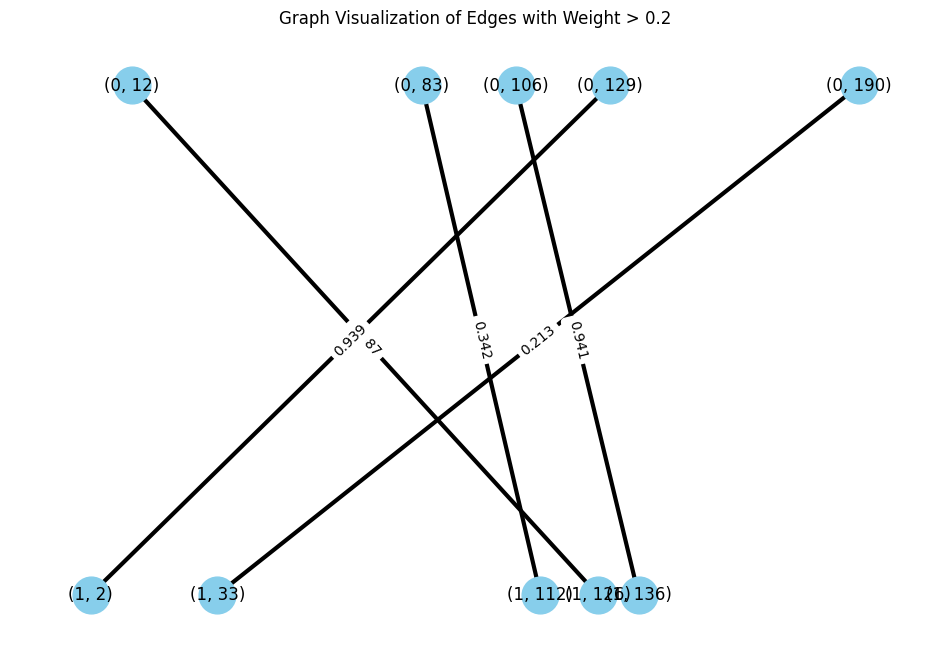

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_layered_graph(edges):
    # Create a graph object
    G = nx.Graph()
    
    # Add edges to the graph, nodes are automatically added
    for (u, v, w) in edges:
        if w > 0.2:
            G.add_edge(u, v, weight=w)

    # Define position layout based on the node labels (layer, feature)
    pos = {node: (node[1], -node[0]) for node in G.nodes()}  # Invert y to have layer 1 on top if desired

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=3)
    edge_labels = {(u, v): round(w, 3) for u, v, w in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos)

    # Set plot options
    plt.title('Graph Visualization of Edges with Weight > 0.2')
    plt.axis('off')  # Hide axes
    plt.show()

plot_layered_graph(edges)
# 2, 129

In [36]:
from pyvis.network import Network

def plot_layered_graph_pyvis(edges):
    # Create a network object with specific size
    net = Network(height="750px", width="100%", notebook=False, bgcolor="#222222", font_color="white")
    
    # Add nodes and edges with selective visibility based on weight
    for (u, v, w) in edges:
        if w > 0.2:
            net.add_node(u[1], label=f"{u[0]}-{u[1]}", title=f"Layer: {u[0]}, Feature: {u[1]}")
            net.add_node(v[1], label=f"{v[0]}-{v[1]}", title=f"Layer: {v[0]}, Feature: {v[1]}")
            net.add_edge(u[1], v[1], value=w, title=f"Weight: {w:.3f}")

    # Generate positions based on layer and feature indices
    for node in net.nodes:
        node_id = node['id']
        node['x'] = node_id * 100  # space out by feature index
        node['y'] = node_id * 100

    # Set physics for better stability in layout
    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -30000,
          "centralGravity": 0.3,
          "springLength": 95,
          "springConstant": 0.04,
          "damping": 0.09,
          "avoidOverlap": 0.2
        },
        "maxVelocity": 50,
        "minVelocity": 0.1,
        "timestep": 0.5
      }
    }
    """)

    # Display the network
    net.show("graph.html")

plot_layered_graph_pyvis(edges)

graph.html


AttributeError: 'NoneType' object has no attribute 'render'